## Importing Libraries

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier, cv, plot_importance
sns.set()
%matplotlib inline

## Part 1: Exploratory Data Analysis

In [2]:
# Creating dataframe from json file
login_df = pd.read_json('logins.json')

In [3]:
# Inspecting the head() of the dataframe
login_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
# Inspecting the data type of the column
login_df['login_time'].dtype

dtype('<M8[ns]')

In [5]:
login_df['login_count'] = 1

In [6]:
# login_df['Day'] = login_df['login_time'].dt.day

In [7]:
login_df.head()

,login_time,login_count
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [8]:
login_df = login_df.set_index('login_time')

In [9]:
login_df.head()

,login_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [10]:
# df_log.resample('15T', how='sum')
login_df = login_df.resample('15T').sum()

In [11]:
# sample per day
# login_df[:96].head(96)  # day 1
# login_df[96:192].head(96) # day 2

In [12]:
login_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   login_count  9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


In [13]:
days = {'0': 'Monday','1': 'Tuesday', '2': 'Wednesday', '3': 'Thursday', '4': 'Friday', '5': 'Saturday', '6': 'Sunday'}

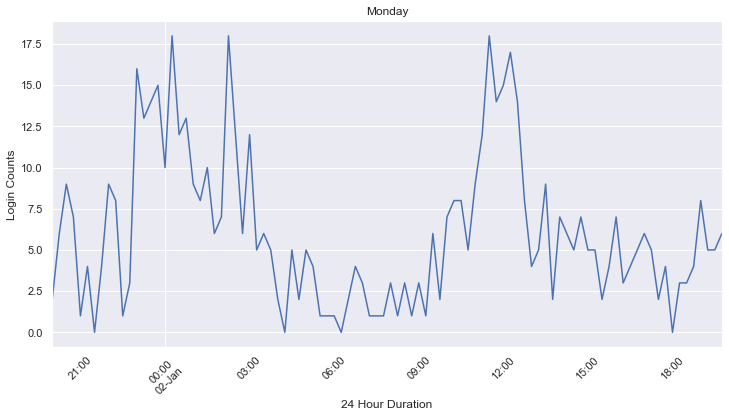

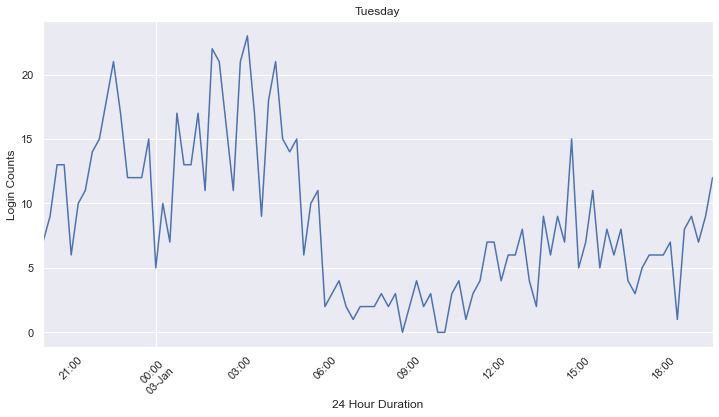

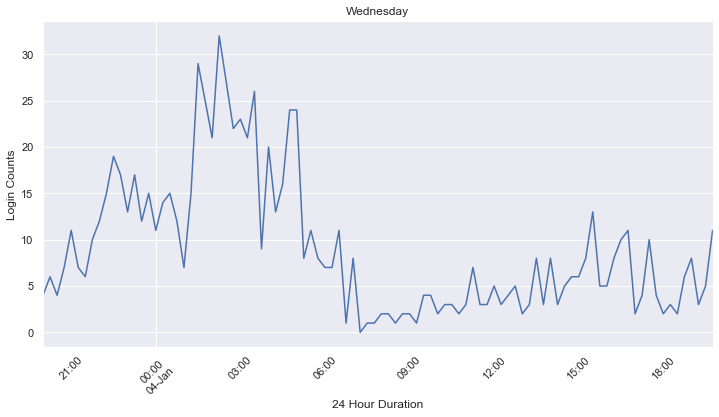

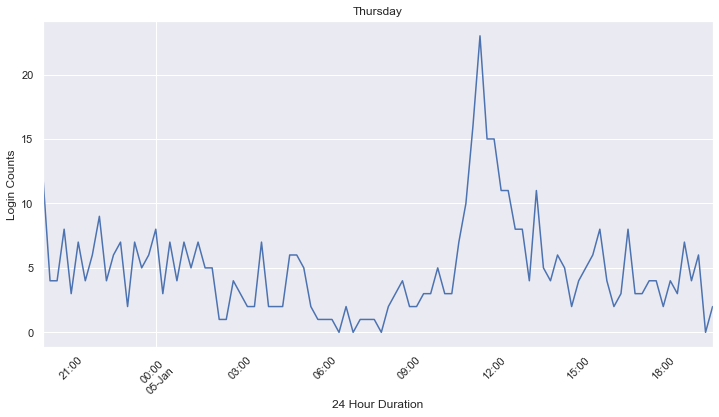

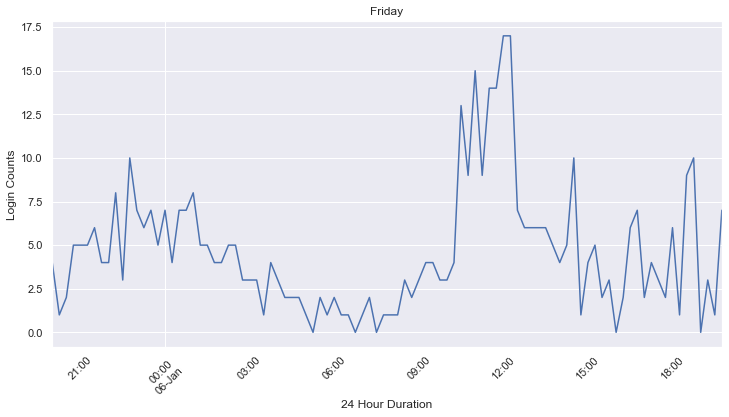

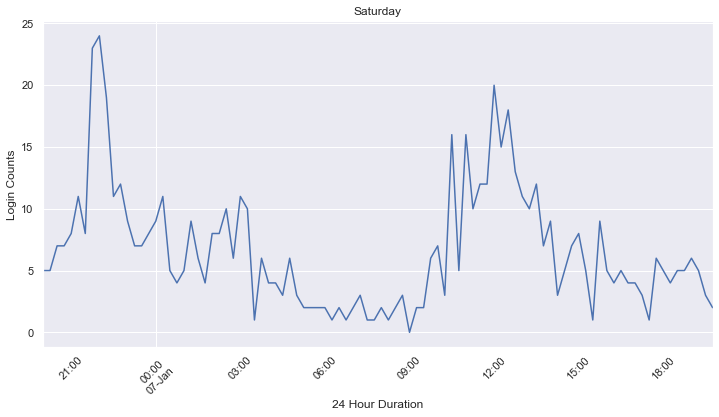

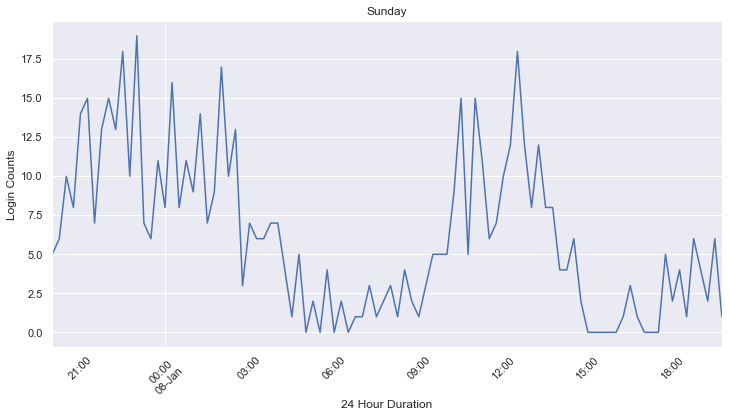

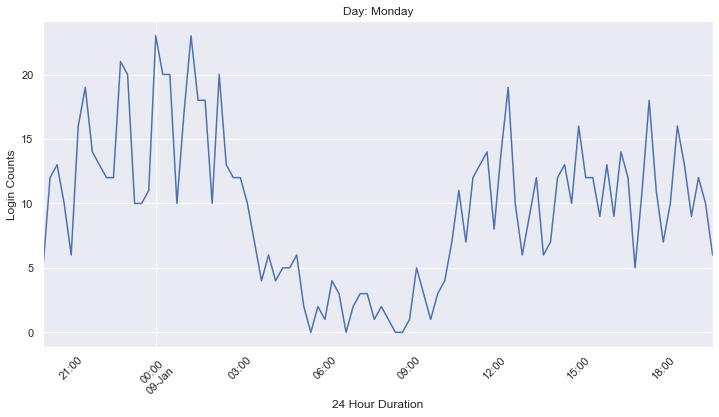

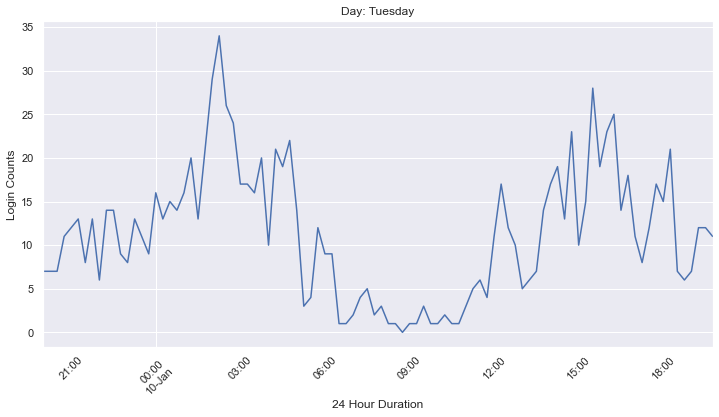

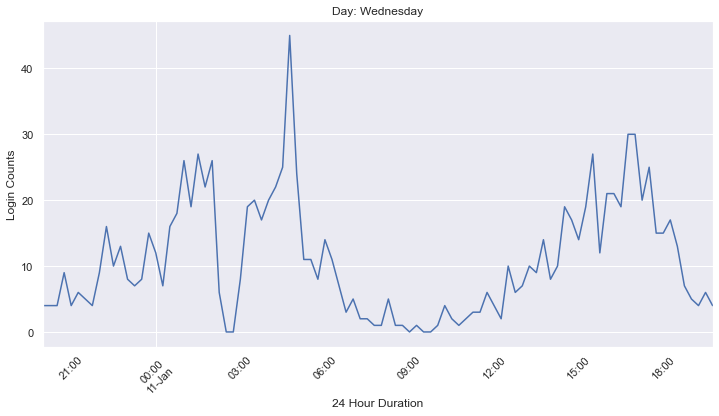

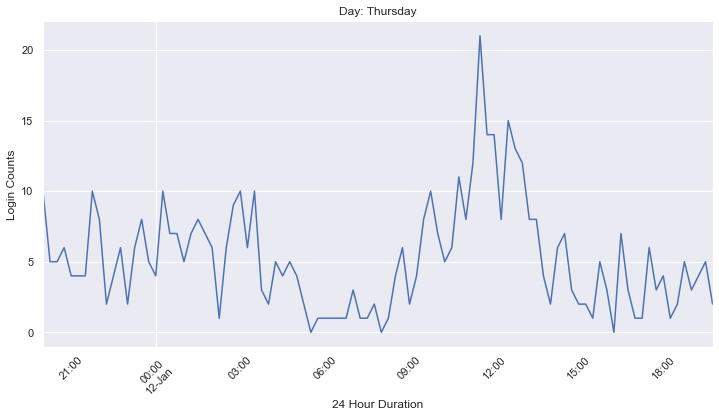

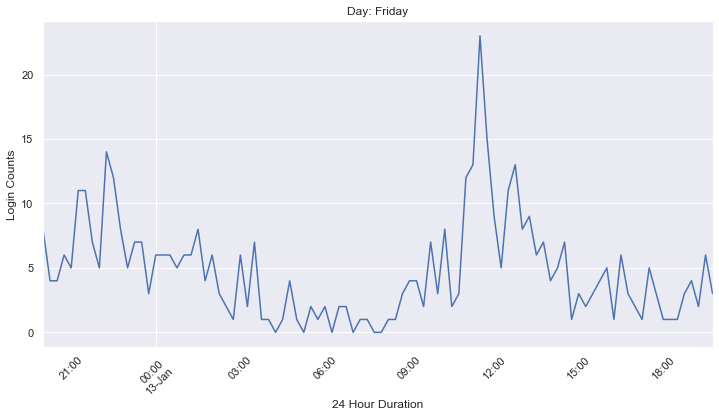

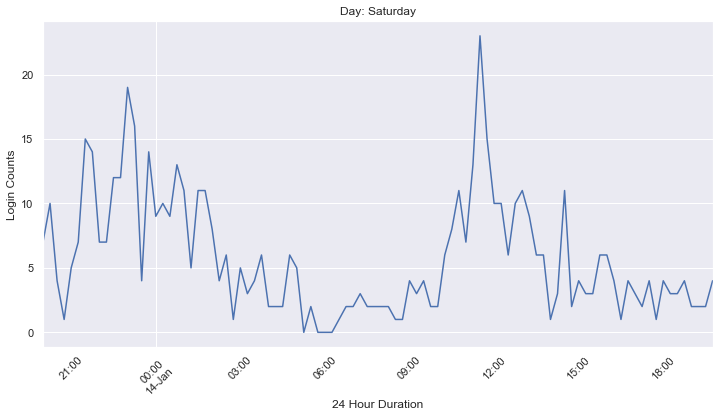

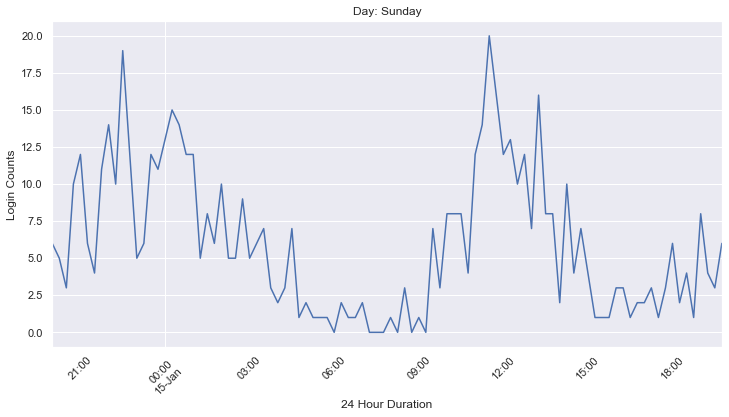

In [14]:
# Visualization of 14 days login count to see the pattern
i = 0
j = 96
for day in range(14):
    plt.figure(figsize=(12,6))
    login_df['login_count'][i:j].plot(rot=45)
    i=j
    j=j+96
    if day<=6:
        plt.title(f"{days[str(day)]}")
        plt.xlabel('24 Hour Duration')
        plt.ylabel('Login Counts')
        plt.show()
    else:
        day_next = day-7
        plt.title(f"Day: {days[str(day_next)]}")
        plt.xlabel('24 Hour Duration')
        plt.ylabel('Login Counts')
        plt.show()


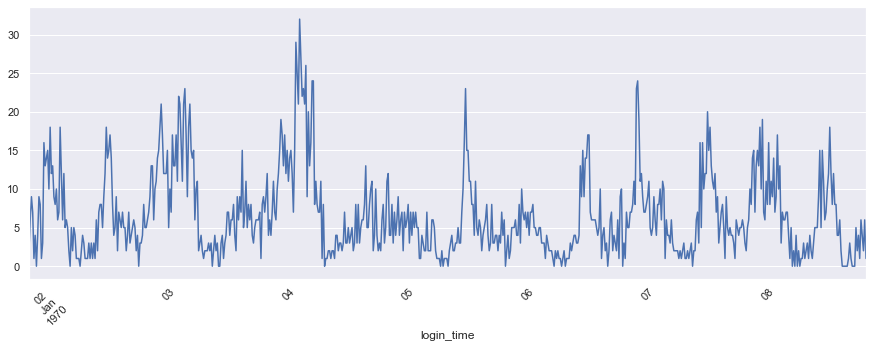

In [15]:
# first week login counts visualization
plt.figure(figsize=(15, 5))
login_df['login_count'][:672].plot(rot=45)
plt.show()

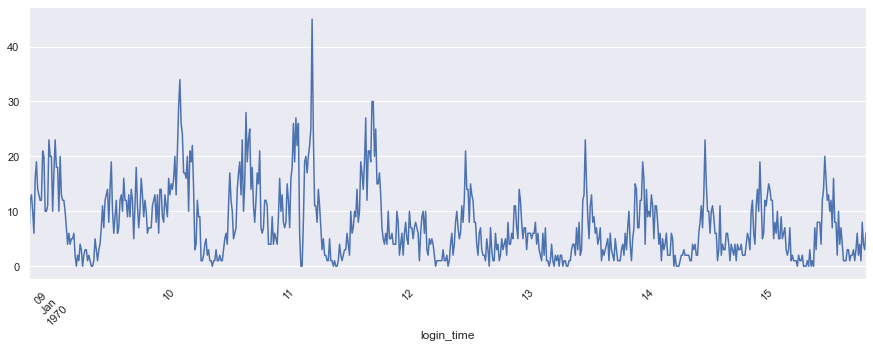

In [16]:
# Second week login counts visualization
plt.figure(figsize=(15, 5))
login_df['login_count'][672:1344].plot(rot=45)
plt.show()

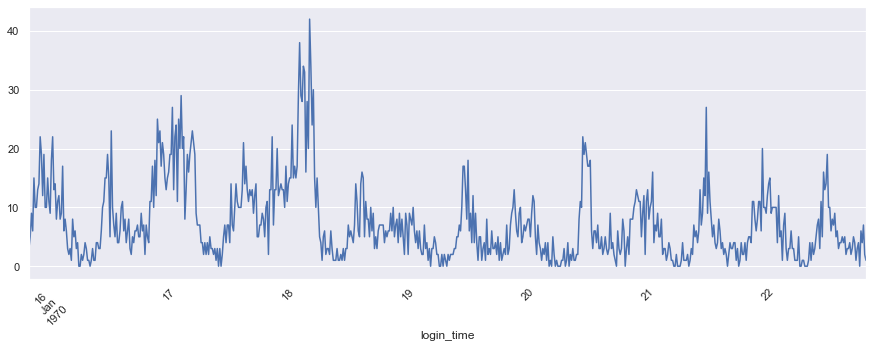

In [17]:
# Third weeks login counts visualization
plt.figure(figsize=(15, 5))
login_df['login_count'][1344:2016].plot(rot=45)
plt.show()

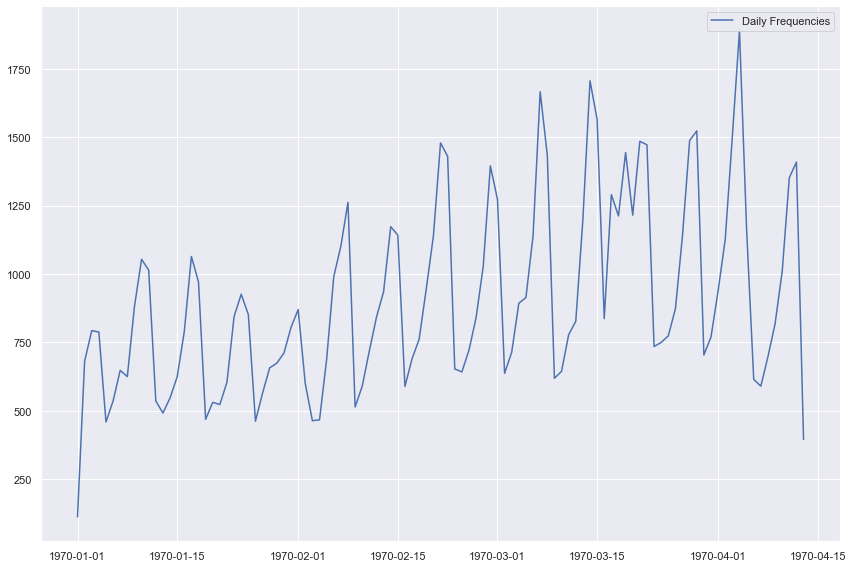

In [78]:
daily_logins = login_df.resample('D').sum()
plt.figure(figsize=(12,8))
plt.plot(daily_logins.index, daily_logins.login_count, label = 'Daily Frequencies')
plt.legend()
plt.tight_layout()
plt.show()

After observing the login counts for 14 consequitive days its visible that there is not similar patter for login counts each day. Although, I have found some similarities of the login counts: 
1. There is no treand ine the data, only exists a weak seasonality
2. Compare to the other days of the week, Wednesday is little bit busy
3. Peak login counts occur at around midnight and at around noon.
4. At morning 6.00 am and evening 6.00 pm each day the login counts reaches at the minimum.
5. There is no significance difference between weekdays and weekend login rates

## Part 2: Experiment and Metric Design

To solve the problem, I will suggest to offer some extra bonuses to driver partners to receive longer trips in addition to reimbursing all tool costs so that the driver partners can move from one city to another during weekend as well as weekdays. After that, I will run a hypothesis after observing one months riders availability in each city and a record of bridge crossing / bridge use by drivers. Also, to increase drivers availabilty on weekend, I will suggest to offer some extra bonuses to driver partners on weekend.

I will use two hypothesis tests. One hypothesis for driver availability in each cities and another hypothesis for tool bridge usage by drivers.

H0: There is no difference between the mean number of cars entering the bridge by observing one months data after reimbursing all tool cost.

H2: There is an increase in the mean number of cars entering the bridge by observing one months data after reimbursing all tool cost..

H0: Drivers availabily in each city remain same.
H2: Drivers availability in each city is changed due to reimbursement.

I would use a Z-test to determine the p-value of each hypothesis.

If the p-value is less than 0.05 for both tests I would reject the null hypotheses and recommend the reimbursement program to continue.

If the p-value is greater than 0.05 for both tests I would fail to reject the null hypotheses and recommend to implement a different approach to increase driver partners availability in both cities.

## Part 3: Predictive Modeling

### Step 1: Data Wrangling and EDA

#### Loading data

In [18]:
# Creating dataframe from rider data
rider_df = pd.read_json('ultimate_data_challenge.json')

#### Inspecting DataFrame

In [19]:
rider_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [20]:
rider_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


The data type of 'signup_date' and 'last_trip_date' columns is object. I need to change them to 'datatime64' type

In [21]:
rider_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


#### Changing data type of some columns

In [22]:
# converting the datatype of 'signup' column to datetime object
rider_df['signup_date'] = pd.to_datetime(rider_df['signup_date'])

In [23]:
# converting the datatype of 'last_trip_date' column to datetime object
rider_df['last_trip_date'] = pd.to_datetime(rider_df['last_trip_date'])

In [24]:
# rider_df.info()

In [25]:
print(f"Early signup date: {rider_df['signup_date'].min()}, last signup date: {rider_df['signup_date'].max()}")

Early signup date: 2014-01-01 00:00:00, last signup date: 2014-01-31 00:00:00


In [26]:
print(f"Early trip date: {rider_df['last_trip_date'].min()}, recent trip date: {rider_df['last_trip_date'].max()}")

Early trip date: 2014-01-01 00:00:00, recent trip date: 2014-07-01 00:00:00


#### Creating target column based on 'last_trip_date'

In [27]:
# Threshold date calculation to make target column 'rider_df['active_status']'
# If a rider took a trip after the threshold date he/she is active else inactive
# recent_trip_date is the latest trip took by any riders by observing the 'last_trip_date' column
recent_trip_date = rider_df['last_trip_date'].max()
flashback = timedelta(days=30)
threshold = recent_trip_date - flashback
print(recent_trip_date, threshold)

2014-07-01 00:00:00 2014-06-01 00:00:00


In [28]:
rider_df['active_status'] = rider_df['last_trip_date'].apply(lambda x: 1 if x > threshold else 0 )

In [29]:
rider_df['active_status'].value_counts(normalize=True)

0    0.6338
1    0.3662
Name: active_status, dtype: float64

In [30]:
# Verifying
# (rider_df['last_trip_date'] > threshold).sum()
# (rider_df['last_trip_date'] <= threshold).sum()

#### Manually changing the values of 'ultimate_black_user' column to 1 and 0

In [31]:
rider_df['ultimate_black_user'].value_counts()

False    31146
True     18854
Name: ultimate_black_user, dtype: int64

In [32]:
rider_df['ultimate_black_user'] = rider_df['ultimate_black_user'].replace({True:1, False:0})

In [33]:
rider_df['ultimate_black_user'].value_counts()

0    31146
1    18854
Name: ultimate_black_user, dtype: int64

In [34]:
rider_df[['ultimate_black_user']].head()

,ultimate_black_user
0,1
1,0
2,0
3,1
4,0


#### Inspecting and filling missing values

In [35]:
rider_df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
active_status                0
dtype: int64

#### Filling missing values in phone column based on most common category

In [36]:
rider_df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [37]:
rider_df['phone'] = rider_df['phone'].fillna(rider_df['phone'].unique()[0])

In [38]:
rider_df['phone'].value_counts()

iPhone     34978
Android    15022
Name: phone, dtype: int64

#### Filling missing values in 'avg_rating_of_driver' column based on mean rating of active and inactive riders

In [39]:
# mean ratings of driver when active status == 1
# active_mean_rating_of_driver = np.mean(rider_df.loc[rider_df['active_status']==1, 'avg_rating_of_driver'])
# inactive_mean_rating_of_driver = np.mean(rider_df.loc[rider_df['active_status']==0, 'avg_rating_of_driver'])
# rider_df['avg_rating_of_driver'] = rider_df['avg_rating_of_driver'].fillna\
# (pd.Series(np.where(rider_df['active_status'] == 1, active_mean_rating_of_driver, inactive_mean_rating_of_driver)))

In [40]:
rider_df['avg_rating_of_driver'].isna().sum()

8122

In [41]:
rider_df[rider_df['avg_rating_of_driver'].isna()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_status
6,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,Android,0.0,0,100.0,3.95,4.0,0
9,Winterfell,1,2014-01-03,NaN,1.0,2014-01-05,Android,0.0,0,0.0,2.37,5.0,0
12,Winterfell,1,2014-01-15,NaN,1.0,2014-03-12,iPhone,0.0,0,100.0,20.29,5.0,0
14,Astapor,1,2014-01-27,NaN,1.0,2014-01-28,Android,0.0,0,100.0,26.01,5.0,0
15,Winterfell,1,2014-01-15,NaN,1.0,2014-01-16,Android,0.0,1,100.0,13.20,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49984,Winterfell,1,2014-01-26,NaN,1.0,2014-01-26,Android,0.0,0,0.0,3.50,5.0,0
49985,Astapor,1,2014-01-26,NaN,1.0,2014-02-25,Android,0.0,0,100.0,1.38,5.0,0
49989,Winterfell,1,2014-01-24,NaN,1.0,2014-01-31,iPhone,0.0,0,100.0,0.00,5.0,0
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,0,0.0,0.00,4.0,0


In [42]:
rider_df['avg_rating_of_driver'].value_counts()

5.0    20771
4.0     4193
4.5     2498
4.8     2430
4.7     1945
4.9     1771
4.3     1487
4.6     1143
3.0     1003
4.4      829
4.2      601
3.5      488
3.8      428
4.1      398
3.7      364
1.0      256
3.9      255
2.0      209
3.3      201
3.6      172
3.4      108
2.5       94
3.2       53
2.7       47
3.1       39
2.8       28
2.3       22
2.9       13
2.6       12
2.1        6
1.5        4
2.4        3
1.8        2
1.7        2
2.2        1
1.6        1
1.9        1
Name: avg_rating_of_driver, dtype: int64

In [43]:
rider_df['avg_rating_of_driver'] = rider_df['avg_rating_of_driver'].fillna(np.mean(rider_df['avg_rating_of_driver']))

In [44]:
rider_df['avg_rating_of_driver'].isna().sum()

0

#### Filling missing values in 'avg_rating_by_driver' column based on mean rating of active and inactive riders

In [45]:
rider_df['avg_rating_by_driver'].isna().sum()

201

In [46]:
# filling missing values on 'avg_rating_by_driver' column based on based on riders active status
rider_df['avg_rating_by_driver'] = rider_df['avg_rating_by_driver'].fillna(np.mean(rider_df['avg_rating_by_driver']))

In [47]:
rider_df['avg_rating_by_driver'].isna().sum()

0

#### Inspecting Correlation among attributes

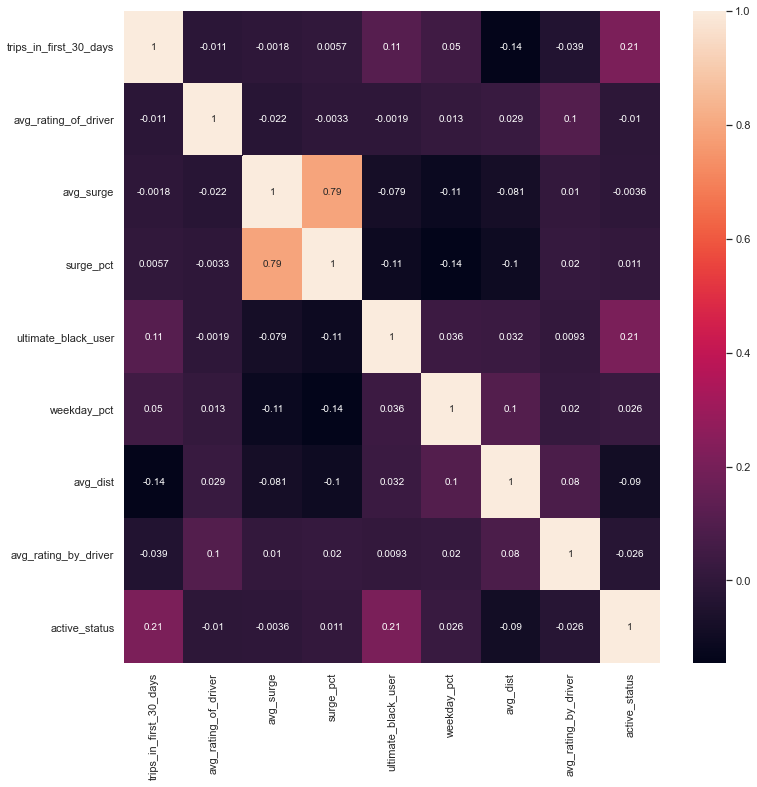

In [48]:
plt.figure(figsize=(15,12))
sns.heatmap(rider_df.corr(), annot=True)
plt.show()

In [49]:
# rider_df = rider_df.dropna()

### Step 2: Preprocessing

In [50]:
rider_df.shape

(50000, 13)

In [51]:
X = rider_df.drop(['active_status', 'signup_date', 'last_trip_date'], axis=1)
y = rider_df.active_status

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [53]:
# Reindexing all four splits
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [54]:
# Defining StandardScaler
scaler = StandardScaler()

In [55]:
X_train[X_train.select_dtypes('number').columns] = scaler.fit_transform(X_train[X_train.select_dtypes('number').columns])
X_test[X_test.select_dtypes('number').columns] = scaler.fit_transform(X_test[X_test.select_dtypes('number').columns])

In [56]:
# Encoding Categorical Columns
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [57]:
X_train.columns

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'city_King's Landing', 'city_Winterfell',
       'phone_iPhone'],
      dtype='object')

In [58]:
X_test.columns

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'city_King's Landing', 'city_Winterfell',
       'phone_iPhone'],
      dtype='object')

In [59]:
X_train.shape, X_test.shape

((37500, 11), (12500, 11))

In [60]:
y_train.shape, y_test.shape

((37500,), (12500,))

In [61]:
y_test.head()

0    1
1    1
2    0
3    0
4    0
Name: active_status, dtype: int64

### Step 3: Modeling

#### Logistic Regression Classifier

In [62]:
# define models and parameters
c_space = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'C': c_space, 'penalty' : ['l2']}
logreg = LogisticRegression(solver='newton-cg', max_iter=100)

# define randomized search cv and train the training dataset
logreg_cv = GridSearchCV(logreg, param_grid = param_grid, cv = 5)
best_model = logreg_cv.fit(X_train, y_train)

# Get the optimum hyperparameter
best_params = best_model.best_params_
print('Best Parameters:', best_params)
print('Best Score:', best_model.best_score_)

Best Parameters: {'C': 0.01, 'penalty': 'l2'}
Best Score: 0.7265333333333333


Model: LogisticRegression(C=0.01)
Precision Score: 0.670
Recall Score: 0.481
Training Accuracy: 0.727
Test Accuracy: 0.723
F1 Score: 0.711


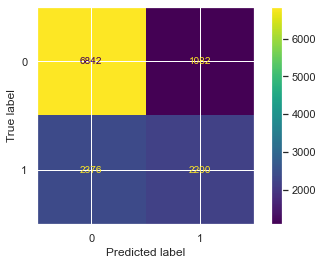

In [63]:
# Create the optimum Logistic Regression Classifier
optimum_logreg = LogisticRegression(C = best_params['C'], penalty = best_params['penalty'])

#Train the model using the training sets
optimum_logreg.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = optimum_logreg.predict(X_test)

# Measuring model's performance using different evaluation metrics
print('Model:', optimum_logreg)
print('Precision Score: %.3f' % (precision_score(y_test, y_pred)))
print('Recall Score: %.3f' % (recall_score(y_test, y_pred)))
print('Training Accuracy: %.3f' % (optimum_logreg.score(X_train, y_train)))
print('Test Accuracy: %.3f' % (optimum_logreg.score(X_test, y_test)))
print('F1 Score: %.3f' % (f1_score(y_test, y_pred, average='weighted')))
print(plot_confusion_matrix(optimum_logreg, X_test, y_test, values_format = 'd' ))
plt.savefig(f"Confusion_Matrix_For_Logistic_Regression.png", dpi=300)

#### Gradient Boosting Classifier

In [64]:
# Define models and perform Hyper parameter tuning
param_grid = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.0001,0.001,0.01,0.1,1,10]
}

gbc = GradientBoostingClassifier()

# define randomized search cv and train the training dataset
gbc_cv = RandomizedSearchCV(gbc, param_distributions = param_grid, cv = 5)
best_model = gbc_cv.fit(X_train, y_train)

# Get the optimum hyperparameter
best_params = best_model.best_params_
print('Best Parameters:', best_params)
print('Best Score:', best_model.best_score_)

Best Parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1}
Best Score: 0.7938133333333333


Model: GradientBoostingClassifier(max_depth=5, n_estimators=500)
Precision Score: 0.663
Recall Score: 0.732
Training Accuracy: 0.849
Test Accuracy: 0.766
F1 Score: 0.768


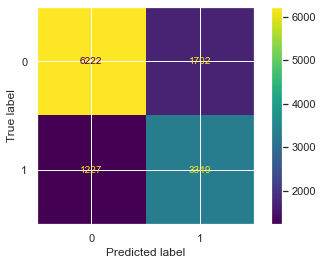

In [65]:
# Create the optimum Gradient Boosting Classifier

gbc = GradientBoostingClassifier(n_estimators = best_params['n_estimators'], learning_rate = best_params['learning_rate'], max_depth = best_params['max_depth'])

#Train the model using the training sets
optimum_gbc = gbc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = optimum_gbc.predict(X_test)

# Measuring model's performance using different evaluation metrics
print('Model:', optimum_gbc)
print('Precision Score: %.3f' % (precision_score(y_test, y_pred)))
print('Recall Score: %.3f' % (recall_score(y_test, y_pred)))
print('Training Accuracy: %.3f' % (optimum_gbc.score(X_train, y_train)))
print('Test Accuracy: %.3f' % (optimum_gbc.score(X_test, y_test)))
print('F1 Score: %.3f' % (f1_score(y_test, y_pred, average='weighted')))
print(plot_confusion_matrix(optimum_gbc, X_test, y_test, values_format = 'd' ))
plt.savefig(f"Confusion_Matrix_For_GB.png", dpi=300)

#### XGBoost Classifier

In [66]:
# Define models and parameters
param_grid = {'max_depth':range(3,10,1), 'min_child_weight':range(1,7,2), 
              'gamma':[i/10.0 for i in range(0,6)], 'n_estimators' : list(range(100,2000,100)), 
              'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}

xgb_clf = XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric="logloss")

# define randomized search cv and train the training dataset
xgb_cv = RandomizedSearchCV(xgb_clf, param_distributions = param_grid, cv = 5, verbose=1, n_jobs=-1)
best_model = xgb_cv.fit(X_train, y_train)

# Get the optimum hyperparameter
best_params = best_model.best_params_
print('Best Parameters:', best_params)
print('Best Score:', best_model.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.2min finished


Best Parameters: {'reg_alpha': 0.01, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'gamma': 0.4}
Best Score: 0.7958133333333333


Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0.4, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0.01, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)
Precision Score: 0.672
Recall Score: 0.727
Training Accuracy: 0.810
Test Accuracy: 0.770
F1 Score: 0.772


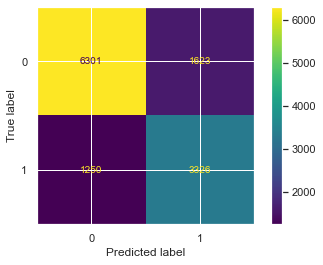

In [67]:
# Instantiate the optimum XGBClassifier: xgb_cl

xgb_cl = XGBClassifier(objective='binary:logistic', use_label_encoder=False, n_jobs=-1,
                          reg_alpha = best_params['reg_alpha'], n_estimators = best_params['n_estimators'],
                          min_child_weight = best_params['min_child_weight'], max_depth = best_params['max_depth'],
                          gamma = best_params['gamma'], eval_metric='logloss')
               

# Fit the classifier to the training set
optimum_xgb = xgb_cl.fit(X_train, y_train)


# Predict the labels of the test set: preds
y_pred = optimum_xgb.predict(X_test)

# Measuring model's performance using different evaluation metrics
print('Model:', optimum_xgb)
print('Precision Score: %.3f' % (precision_score(y_test, y_pred)))
print('Recall Score: %.3f' % (recall_score(y_test, y_pred)))
print('Training Accuracy: %.3f' % (optimum_xgb.score(X_train, y_train)))
print('Test Accuracy: %.3f' % (optimum_xgb.score(X_test, y_test)))
print('F1 Score: %.3f' % (f1_score(y_test, y_pred, average='weighted')))
print(plot_confusion_matrix(optimum_xgb, X_test, y_test, values_format = 'd'))
plt.savefig(f"onfusion_Matrix_For_XGB.png", dpi=300)

### Step 4: Results and Findings

In [68]:
# feature importance of Gradient Boosting Classifier
feature_dict = {'columns': X_test.columns, 'feature_importance':optimum_xgb.feature_importances_}
df_feature = pd.DataFrame(feature_dict)
df_feature.head(15)

,columns,feature_importance
0,trips_in_first_30_days,0.022770
1,avg_rating_of_driver,0.015894
2,avg_surge,0.007539
3,surge_pct,0.085448
4,ultimate_black_user,0.155588
5,weekday_pct,0.052609
6,avg_dist,0.009763
7,avg_rating_by_driver,0.131126
8,city_King's Landing,0.246398
9,city_Winterfell,0.044277


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

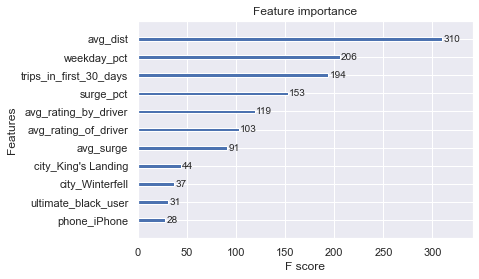

In [69]:
# Feature importance of XGBoost Classifier
plot_importance(optimum_xgb)

By observing the last months activity on 'last_trip_date' column, I have fond that 36.62% of the riders is currently active and the rest 63.38% is inactive.

I have implemented several machine learning algorithms and evaluated the performance on test data. Initially, the model was showing moderate performance on test data. After hyperparameter tuning the model's performance on test data was increasing and I have received more than 80% accuracy on test data from XGBoost classifier.

The predictor variables that will influence most on rider retention is 'avg_dist', 'weekday_pct', 'trips_in_first_30_days'. Riding longer trips as well as riding more on weekends will influence the rider's retention, which can be implemented by offering discount on longer trips and promoting riders to ride more on weekends.